In [1]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import LC
from LC_Set import LC_Set
from fermi_catalog import select_bll, select_fsrq, select_bcu

from matplotlib.ticker import FormatStrFormatter

# COSI Analysis

## Daily

In [133]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [160]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 22 #Counts / s


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        background_counts = COSI_bkg_rate * duration
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration,background_counts]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts)
    
    return mdp99

In [158]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]/100

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]
        background_counts = flarestack[:,3]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration,background_counts]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_daily_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_daily_df.columns=['Name','Photon Counts','Duration (s)','Background Counts']

COSI_BAND_ALL_daily_df


0
9.96e-07 6.39e-09 9.8961e-07 9.896100000000001e-08 1.05351e-07
<class 'list'>
 
[['0' '0' '0' '0']
 ['4FGL J0538.8-4405' '8.01767808' '25531200.0' '561686400.0']
 ['4FGL J0538.8-4405' '32.26073184' '81388800.0' '1790553600.0']
 ['4FGL J0538.8-4405' '9.00528192' '56246400.0' '1237420800.0']
 ['4FGL J0538.8-4405' '1.94819904' '16848000.0' '370656000.0']
 ['4FGL J0538.8-4405' '0.98467488' '8035200.0' '176774400.0']
 ['4FGL J0538.8-4405' '2.6540265599999997' '22939200.0' '504662400.0']
 ['4FGL J0538.8-4405' '1.4440291200000002' '14644800.0' '322185600.0']
 ['4FGL J0538.8-4405' '2.1941020799999995' '10238400.0' '225244800.0']
 ['4FGL J0538.8-4405' '8.858471040000001' '47952000.0' '1054944000.0']
 ['4FGL J0538.8-4405' '0.53034912' '3888000.0' '85536000.0']
 ['4FGL J0538.8-4405' '1.5995232' '8812800.0' '193881600.0']
 ['4FGL J0538.8-4405' '9.3453264' '38620800.0' '849657600.0']]
aaaaaaa
[  0.         150.20711668 604.38838569 168.70937179  36.4985171
  18.44738254  49.72183632  27.05315035 

,Name,Photon Counts,Duration (s),Background Counts
0,0,0,0,0
1,0,0.0,0,0
2,4FGL J0538.8-4405,150.20711668253008,25531200.0,561686400.0
3,4FGL J0538.8-4405,604.388385690174,81388800.0,1790553600.0
4,4FGL J0538.8-4405,168.70937179315118,56246400.0,1237420800.0
...,...,...,...,...
735,4FGL J0428.6-3756,0.3445793415740104,518400.0,11404800.0
736,4FGL J0428.6-3756,7.202721707548504,7516800.0,165369600.0
737,4FGL J0428.6-3756,6.56052040526204,7257600.0,159667200.0
738,4FGL J0428.6-3756,2.5556301166739104,3888000.0,85536000.0


In [ ]:
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df['Photon Counts']= COSI_BAND_ALL_daily_df['Photon Counts'].astype(float)
COSI_BAND_ALL_daily_df['Duration (days)'] = COSI_BAND_ALL_daily_df['Duration (s)'].astype(float)/(86400)
COSI_BAND_ALL_daily_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Counts'],COSI)


#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
COSI_BAND_ALL_daily_df

,Name,Photon Counts,Duration (s),Background Counts,Duration (days)
0,4FGL J0538.8-4405,150.207117,25531200.0,561686400.0,295.5
1,4FGL J0538.8-4405,604.388386,81388800.0,1790553600.0,942.0
2,4FGL J0538.8-4405,168.709372,56246400.0,1237420800.0,651.0
3,4FGL J0538.8-4405,36.498517,16848000.0,370656000.0,195.0
4,4FGL J0538.8-4405,18.447383,8035200.0,176774400.0,93.0
...,...,...,...,...,...
578,4FGL J0428.6-3756,0.344579,518400.0,11404800.0,6.0
579,4FGL J0428.6-3756,7.202722,7516800.0,165369600.0,87.0
580,4FGL J0428.6-3756,6.560520,7257600.0,159667200.0,84.0
581,4FGL J0428.6-3756,2.555630,3888000.0,85536000.0,45.0


In [137]:
print(COSI_BAND_ALL_daily_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


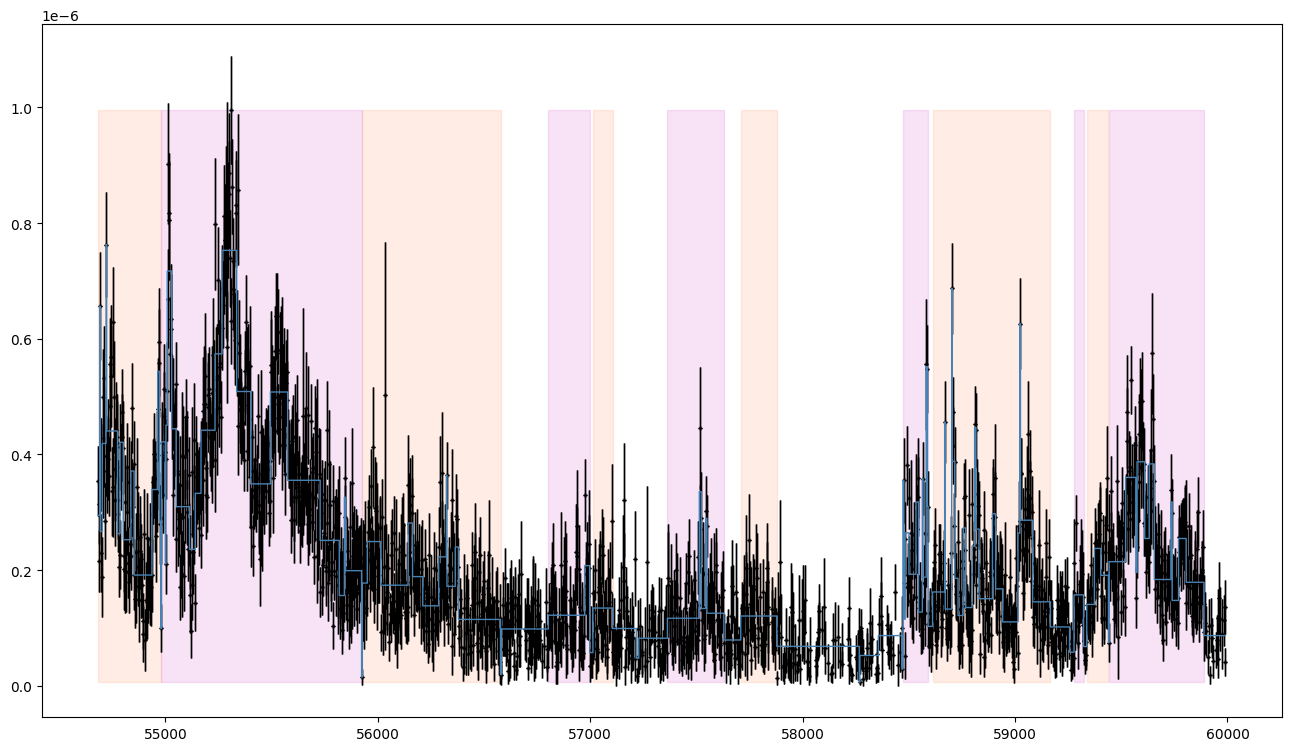

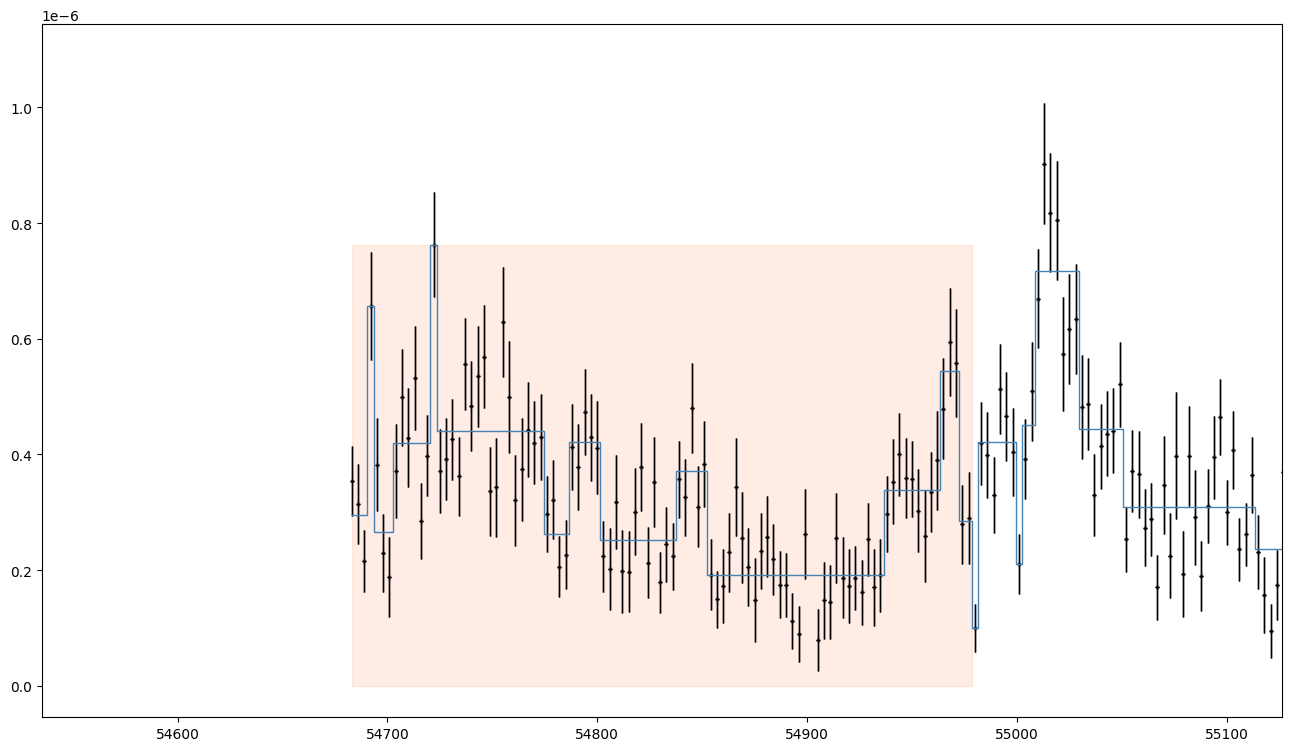

In [138]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [139]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3.  1.  3.  6.  1. 17.  4.  5. 12.  5. 27.  9.  3.  2.  1.  6.  1.  2.
  7.  7. 21.  9.  9. 22. 11. 23. 22. 31. 27. 50. 30.  8.  2. 25.  1.  8.
 21. 42.  7. 14. 22. 12.  1. 13.  5. 59.  1. 61. 50.  8.  5. 29. 30.  3.
 32. 45.  3.  6.  2. 22. 22. 47. 62.  1. 19. 16.  1.  1.  2.  5. 11.  4.
  6.  1.  5.  2.  1.  7. 19.  1.  9.  1.  4.  5.  8.  4. 10.  4.  2.  5.
 21.  5. 11. 24.  3.  1. 19. 26. 26.  5. 14.  5. 12. 10. 12.  1. 26. 16.
  2. 12.  7.  8. 26.  2. 10. 12. 28. 19.]


In [140]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54684.50001157, 54687.50001157, 54690.50001157, 54693.50001157,
       54696.50001157, 54699.50001157, 54702.50001157, 54705.50001157,
       54708.50001157, 54711.50001157, 54714.50001157, 54717.50001157,
       54720.50001157, 54723.50001157, 54726.50001157, 54729.50001157,
       54732.50001157, 54735.50001157, 54738.50001157, 54741.50001157,
       54744.50001157, 54747.50001157, 54750.50001157, 54753.50001157,
       54756.50001157, 54759.50001157, 54762.50001157, 54765.50001157,
       54768.50001157, 54771.50001157, 54774.50001157, 54777.50001157,
       54780.50001157, 54783.50001157, 54786.50001157, 54789.50001157,
       54792.50001157, 54795.50001157, 54798.50001157, 54801.50001157,
       54804.50001157, 54807.50001157, 54810.50001157, 54813.50001157,
       54816.50001157, 54819.50001157, 54822.50001157, 54825.50001157,
       54828.50001157, 54831.50001157, 54834.50001157, 54837.50001157,
       54840.50001157, 54843.50001157, 54846.50001157, 54849.50001157,
      

## Weekly

In [101]:
# This is for using the old 2023 dataset.

table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
display(pd.DataFrame(cadence_df))
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

,Unnamed: 0,source_name,cadence,tmin,tmax,photon_flux2,photon_flux_error2,photon_index2,return_code2,ts2
3050,3050,4FGL J0001.2-0747,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.51
3051,3051,4FGL J0001.5+2113,weekly,239587201,240192001,1.480000e-08,1.550000e-08,2.12,0.0,1.47
3052,3052,4FGL J0003.3-1928,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.25
3053,3053,4FGL J0004.3+4614,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.31
3054,3054,4FGL J0004.4-4737,weekly,239587201,240192001,5.030000e-08,3.010000e-08,3.15,0.0,5.02
...,...,...,...,...,...,...,...,...,...,...
4132745,4132745,4FGL J2358.0-4601,weekly,698630401,699235201,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4132746,4132746,4FGL J2358.3-1021,weekly,698630401,699235201,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4132747,4132747,4FGL J2358.3+3830,weekly,698630401,699235201,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4132748,4132748,4FGL J2359.0+3922,weekly,698630401,699235201,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00


In [143]:
# Using the new 2025 dataset. The new dataset has renamed ts2 to return_code2, so the code has been updated accordingly.
table = "new_db_Aug2025.csv"

opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
display(pd.DataFrame(cadence_df))
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

,Unnamed: 0,source_name,cadence,tmin,tmax,photon_flux2,photon_flux_error2,photon_index2,return_code2,ts2
3050,3050,4FGL J0001.2-0747,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.51
3051,3051,4FGL J0001.5+2113,weekly,239587201,240192001,1.480000e-08,1.550000e-08,2.12,0.0,1.47
3052,3052,4FGL J0003.3-1928,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.25
3053,3053,4FGL J0004.3+4614,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.31
3054,3054,4FGL J0004.4-4737,weekly,239587201,240192001,5.030000e-08,3.010000e-08,3.15,0.0,5.02
...,...,...,...,...,...,...,...,...,...,...
4817470,4817470,4FGL J2358.0-4601,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817471,4817471,4FGL J2358.3-1021,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817472,4817472,4FGL J2358.3+3830,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817473,4817473,4FGL J2359.0+3922,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00


In [267]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops"):
        sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)


    if sourcelightcurve.hops is None:
        quiescent_background,qui_err = np.nan, np.nan
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    fsrq_names = select_fsrq()['Source_Name']
    bll_names = select_bll()['Source_Name']
    bcu_names = select_bcu()['Source_Name']
    flarestack=[0,0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum)
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp)
        flare_asym = hops_bl[i].asym
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype,flare_asym]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype,flare_asym]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100
    
    return mdp99

#def flare_detector(cadence_df, COSI_LAT_Sources, percent=0.1, factor=1):
#    flare_array = []
#    COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0])
#    #quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
#    for i,s in COSI_LAT_Sources.iterrows():
#        Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]/100#
#
#        sourcename = COSI_LAT_Sources['Name'][i]#
#
#        factor = COSI_LAT_Sources['ph/s_ratio'][i]
#
#        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
#        titlestring=sourcename


In [307]:
UseFermiBand = False
#table = 'COSICSV/COSI_factors_all_updated_only_logpar.csv'
table = 'UpdatedCSVSJuly7th/COSI_factors_all_updated_only_logpar_flare_softer_+0.5.csv'
#table = 'COSI_factors_all_updated copy.csv'
COSI_bkg_rate = 1
percent = 0.5
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    print(s)
    Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]
    sourcename = COSI_LAT_Sources['Name'][i]
    #
    #if sourcename == '4FGL J1036.3-5833e':
    #    continue
    #if sourcename == '4FGL J1855.9+0121e':
    #    continue
    #if sourcename == '4FGL J1923.2+1408e':
    #    continue

    factor = COSI_LAT_Sources['ph/s_ratio'][i]
    if UseFermiBand == True:
        Aeff = 1
        factor = 1
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.nanmean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
#    if len(sourcelightcurve.time) == 0:
#        continue
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    #thresholdflux = np.nanmean(photon_flux)
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

    if not sourcelightcurve.hops:
        continue

    quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

    if quiescent_background == np.nan:
        continue
    print('printing quiescent background')
    print(quiescent_background)
    #sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

#    if print(hops_bl[i]) == '(array([], dtype=int64),)':
#        continue
#    else:
    hops_bl = sourcelightcurve.hops
    try:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
    except:
        continue
    print(' ')
    print(flarestack)
    print('aaaaaaa')

    flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
    flareflux = flarestack[:,1].astype(float)*factor
    print(flareintegrals)
    print('bbbbbbbbbbbbb')
    flarenames = flarestack[:,0]
    print(flarenames)
    flareduration = flarestack[:,3]
    background_counts = flarestack[:,4]
    starttime_s = flarestack[:,5]
    starttime_mjd = flarestack[:,6]
    fraction_time = flarestack[:,7]
    blazartype = flarestack[:,8]
    asymmetry = flarestack[:,9]

    COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype,asymmetry]).T
    print(COSI_BAND)
    print(COSI_BAND_ALL)
    COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class','Asymmetry']

COSI_BAND_BAT_weekly_df


0
Name                   4FGL J0538.8-4405
ph/s_ratio                       6.06911
Aeff_mean_LAT(cm2)           7770.751013
Aeff_mean_COSI(cm2)             74.89457
Name: 0, dtype: object
8.43e-07 8.06e-09 8.3494e-07 4.1747e-07 4.2552999999999997e-07
Quiescent Background: 1.6811435173299102e-07, Error: 1.3139458982284622e-09
printing quiescent background
1.6811435173299102e-07
-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
1
Name                   4FGL J1104.4+3812
ph/s_ratio                      0.073147
Aeff_mean_LAT(cm2)            7161.02682
Aeff_mean_COSI(cm2)            80.751943
Name: 1, dtype: object
6.54e-07 1.99e-08 6.341e-07 3.1705e-07 3.3695e-07
Quiescent Background: 1.6815752105896509e-07, Error: 1.1123982227416425e-09
printing qu

,Name,Photon Flux (ph/cm2/s),Photon Count,Duration (s),Background Counts,Start Time (s),Start Time (MJD),Fraction of Observation Time,Class,Asymmetry
0,0,0,0,0,0,0,0,0,0,0
1,0,0.0,0.0,0,0,0,0,0,0,0
2,4FGL J1104.4+3812,1.4139388944784347e-07,6.905504393334582,7257600.0,7257600.0,4747896001.0,54952.50001157408,0.01362088535754824,BLL,0.0
3,4FGL J1104.4+3812,1.8096662312155443e-07,8.838188240615498,9072000.0,9072000.0,4755758401.0,55043.50001157408,0.0170261066969353,BLL,0.0
4,4FGL J1104.4+3812,7.8926025201357e-08,3.854650408902232,3628800.0,3628800.0,4766040001.0,55162.50001157408,0.00681044267877412,BLL,0.0
...,...,...,...,...,...,...,...,...,...,...
682,4FGL J1337.6-1257,0.00015476988321862724,7996.102035587408,26913600.0,26913600.0,5086584001.0,58872.50001157408,0.05051078320090806,FSRQ,-0.29213483146067415
683,4FGL J1337.6-1257,0.00014324274256084075,7400.558568335276,17841600.0,17841600.0,5114707201.0,59198.00001157408,0.03348467650397276,FSRQ,0.0847457627118644
684,4FGL J1337.6-1257,1.8494830623981234e-05,955.5253885625589,2116800.0,2116800.0,5134363201.0,59425.50001157408,0.003972758229284903,FSRQ,0.0
685,4FGL J1337.6-1257,0.00011303638172904542,5839.963326471471,27216000.0,27216000.0,5166417601.0,59796.50001157408,0.0510783200908059,FSRQ,0.0


In [ ]:
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!=0].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df['Photon Count']= COSI_BAND_BAT_weekly_df['Photon Count'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (weeks)'] = COSI_BAND_BAT_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_BAT_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Photon Count'].astype(float),COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_BAT_weekly_df['Duration (s)']
COSI_BAND_BAT_weekly_df['Fraction of Observation Time'] = COSI_BAND_BAT_weekly_df['Fraction of Observation Time'].astype(float)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration (s)']<=2e8].reset_index(drop=True)



pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)','Fraction of Observation Time', 'MDP99','Start Time (MJD)', 'Start Time (s)','Asymmetry']
#pd.set_option('display.max_rows',None)
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder]
#COSI_BAND_BAT_weekly_df[neworder].to_csv('Aug2025_COSI_0.5_(1 Counts)_Softer.csv')
COSI_BAND_BAT_weekly_df[neworder].sort_values('MDP99',ascending=True)
#COSI_BAND_BAT_weekly_df[neworder].sort_values('Fraction of Observation Time',ascending=True)



,Name,Class,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),Fraction of Observation Time,MDP99,Start Time (MJD),Start Time (s),Asymmetry
61,4FGL J2253.9+1609,FSRQ,8.909785e-03,458034.215034,453304.603249,51408000.0,51408000.0,85.0,0.096481,2.271787e+01,55050.50001157408,4756363201.0,0.5647058823529412
203,4FGL J1229.0+0202,FSRQ,4.446130e-03,99493.726556,229316.869939,22377600.0,22377600.0,37.0,0.041998,2.964973e+01,55029.50001157408,4754548801.0,-0.5405405405405406
230,4FGL J1229.0+0202,FSRQ,1.794637e-03,17909.041947,92561.512168,9979200.0,9979200.0,16.5,0.018729,4.902960e+01,60734.50001157408,5247460801.0,-0.45454545454545453
199,4FGL J1229.0+0202,FSRQ,1.730959e-03,16750.141614,89277.194036,9676800.0,9676800.0,16.0,0.018161,5.005594e+01,54707.50001157408,4726728001.0,-0.4375
229,4FGL J1229.0+0202,FSRQ,2.221370e-03,37617.568739,114571.005205,16934400.0,16934400.0,28.0,0.031782,5.153596e+01,60531.50001157408,5229921601.0,0.3392857142857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,4FGL J1104.4+3812,BLL,4.081624e-08,0.098743,1.993415,2419200.0,2419200.0,4.0,0.004540,1.115769e+06,56590.50001157408,4889419201.0,0.0
25,4FGL J1104.4+3812,BLL,3.174596e-08,0.057600,1.550434,1814400.0,1814400.0,3.0,0.003405,1.242366e+06,59292.50001157408,5122872001.0,0.0
18,4FGL J1104.4+3812,BLL,2.077386e-08,0.025128,1.014570,1209600.0,1209600.0,2.0,0.002270,1.550155e+06,57850.50001157408,4998283201.0,0.0
26,4FGL J1104.4+3812,BLL,1.828685e-08,0.022120,0.893107,1209600.0,1209600.0,2.0,0.002270,1.760976e+06,59705.50001157408,5158555201.0,0.0


In [278]:
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20].drop_duplicates(subset=['Name'],keep='first')),' sources with MDP99 <= 20')
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20]),' flares with MDP99 <= 20')
#COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['MDP99']<=20].to_csv('COSI_BAND_ALL_weekly_df_MDP99_20Test.csv')
#print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20].drop_duplicates(subset=['Name']))

There are  0  sources with MDP99 <= 20
There are  0  flares with MDP99 <= 20


In [279]:
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50].drop_duplicates(subset=['Name'],keep='first')),' sources with MDP99 <= 50')
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50]),' flares with MDP99 <= 50')
#COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50]#.to_csv('COSI_BAND_ALL_weekly_df_MDP99_50_filtered.csv')
print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50].drop_duplicates(subset=['Name']))

There are  3  sources with MDP99 <= 50
There are  6  flares with MDP99 <= 50
                   Name  Photon Flux (ph/cm2/s)   Photon Count  Duration (s)  \
1759  4FGL J1635.6+3628                0.000724   37461.766046    15724800.0   
2465  4FGL J2253.9+1609                0.002277  109772.847019    51408000.0   
2603  4FGL J1229.0+0202                0.000628   31464.342853     9676800.0   

     Background Counts Start Time (s)   Start Time (MJD)  \
1759         1572480.0   5026104001.0  58172.50001157408   
2465         5140800.0   4756363201.0  55050.50001157408   
2603          967680.0   4726728001.0  54707.50001157408   

      Fraction of Observation Time Class           Asymmetry  \
1759                      0.030197  FSRQ  0.2692307692307692   
2465                      0.096481  FSRQ  0.5647058823529412   
2603                      0.018161  FSRQ             -0.4375   

      Duration (weeks)      MDP99  Fluence (ph/cm2)  
1759              26.0  48.434283      11377.45840

Text(0, 0.5, 'MDP$_{99}$ [%]')

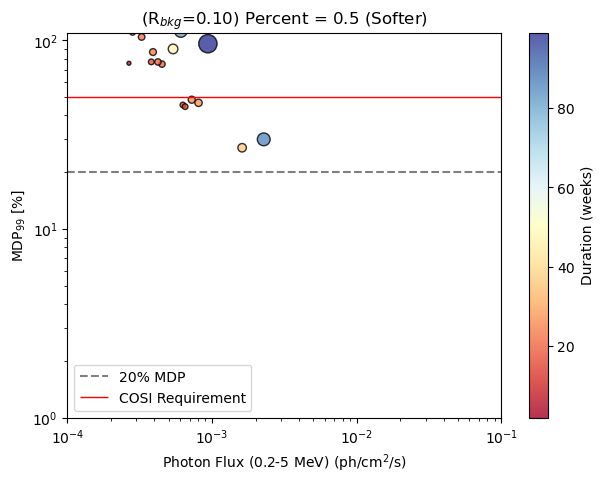

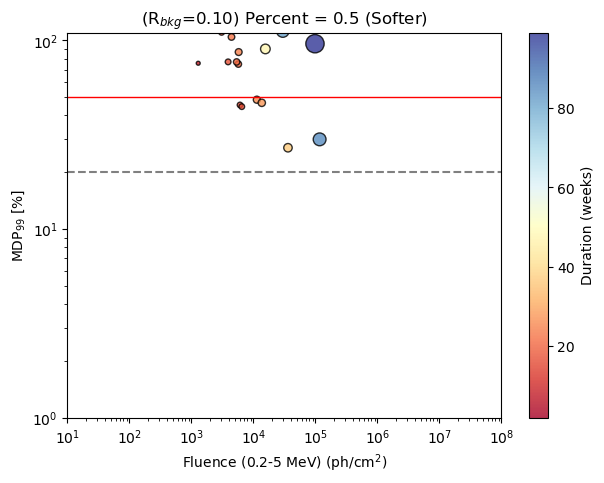

In [280]:
#COSI_BAND_BAT_weekly_df=pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts)_Softer.csv')
#COSI_bkg_rate = 0.1

#plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'])
fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (weeks)']
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
cbar = plt.colorbar(sc)
cbar.set_label('Duration (weeks)')
plt.ylim(1,110)
plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f) Percent = 0.5 (Softer)'%COSI_bkg_rate)
plt.legend(loc=3)
#plt.savefig('Diagrams/COSI_Flux_v_MDP99_Rbkg%.2f_0.1.png'%COSI_bkg_rate, dpi=200)


fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (weeks)']
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
cbar = plt.colorbar(sc)
cbar.set_label('Duration (weeks)')
plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,10,1e+8,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.title(r'(R$_{bkg}$=%.2f) Percent = 0.5 (Softer)'%COSI_bkg_rate)
plt.ylim(1,110)
plt.xlim(10,1e+8)
plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
#plt.savefig('Diagrams/COSI_Fluence_v_MDP99_Rbkg%.2f_0.1.png'%COSI_bkg_rate, dpi=200)

### Testing Sharp Method for Determining Quiescent Background

In [245]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward',thresholdflux=thresholdflux):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = thresholdflux)
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    fsrq_names = select_fsrq()['Source_Name']
    bll_names = select_bll()['Source_Name']
    bcu_names = select_bcu()['Source_Name']
    flarestack=[0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        print(len(hops_bl[i].iis))
        if len(hops_bl[i].iis) > 1:
            temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        else:
            temp = sourcelightcurve.flux[hops_bl[i].iis]
            print(hops_bl[i].iis)
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum)
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp)
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts) * 100
    
    return mdp99

In [246]:

table = 'COSI_factors_all_updated.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]
    #
    #if sourcename == '4FGL J1036.3-5833e':
    #    continue
    #if sourcename == '4FGL J1855.9+0121e':
    #    continue
    #if sourcename == '4FGL J1923.2+1408e':
    #    continue

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward',thresholdflux=thresholdflux)
    #sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)
    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
        flareflux = flarestack[:,1].astype(float)*factor
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,3]
        background_counts = flarestack[:,4]
        starttime_s = flarestack[:,5]
        starttime_mjd = flarestack[:,6]
        fraction_time = flarestack[:,7]
        blazartype = flarestack[:,8]

        COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class']

COSI_BAND_BAT_weekly_df


FileNotFoundError: [Errno 2] No such file or directory: 'COSI_factors_all_updated.csv'

### Duty Cycle Calculations

In [281]:
dutycycle_arr=[0,0,0]
#COSI_BAND_BAT_weekly_df=pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts).csv')
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.1Softer.csv')
print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
    sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
    if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
        blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
    else:
        blazartype = 'BCU'
    #print(blazartype)
    dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
    print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

    #print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
    #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    #print('obstime is',obstime)
    dutycycle = [sourcename,dutycyclevalue,blazartype]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

422
0    0.0
Name: Fraction of Observation Time, dtype: float64
1     0.005137
2     0.002283
3     0.018265
4     0.006279
5     0.006849
6     0.014840
7     0.002854
8     0.014269
9     0.007991
10    0.030822
11    0.004566
12    0.003995
13    0.004566
Name: Fraction of Observation Time, dtype: float64
14    0.0375
Name: Fraction of Observation Time, dtype: float64
15    0.191047
16    0.258512
17    0.013871
Name: Fraction of Observation Time, dtype: float64
18    0.093037
19    0.056507
20    0.259132
Name: Fraction of Observation Time, dtype: float64
21    0.025597
22    0.047213
23    0.004551
24    0.031286
25    0.182025
26    0.005688
27    0.011945
Name: Fraction of Observation Time, dtype: float64
28    0.192841
Name: Fraction of Observation Time, dtype: float64
29    0.280854
30    0.292964
31    0.162053
32    0.107843
Name: Fraction of Observation Time, dtype: float64
33    0.007955
34    0.121591
35    0.004545
36    0.090341
37    0.101136
Name: Fraction of Observat

Text(0.5, 1.0, 'Duty Cycle Ratio Distribution BCUs')

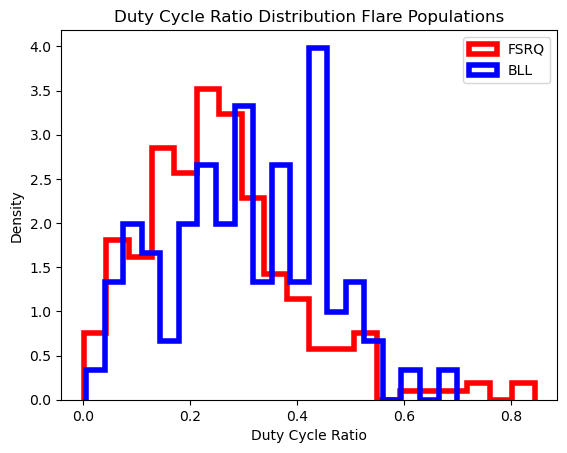

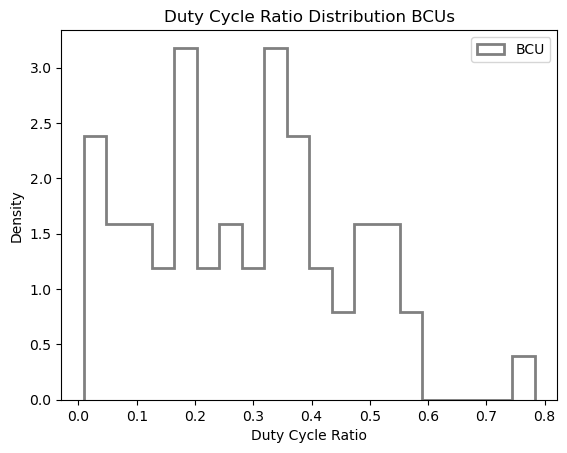

In [282]:
filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
#pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('DutyCyclesFSRQBLL.csv',index=False)
plt.figure()
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution of FSRQs')
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution Flare Populations')
plt.figure()
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5.png')

plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution BCUs')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5.png')
#plt.yscale('log')
#plt.xscale('log')

<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/3489312684.py:46: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/3489312684.py:46: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma

0.15608074858341606 0.21703310229192962


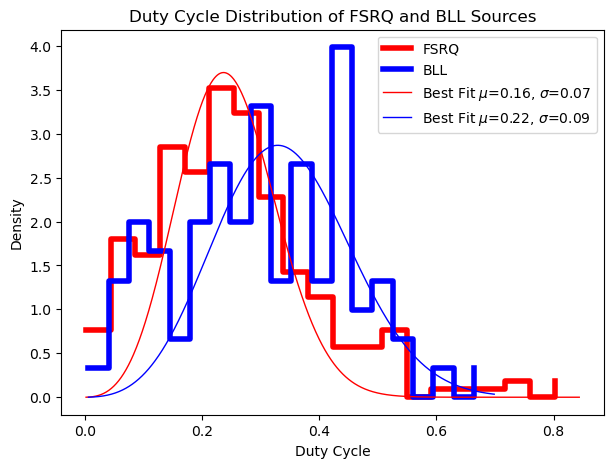

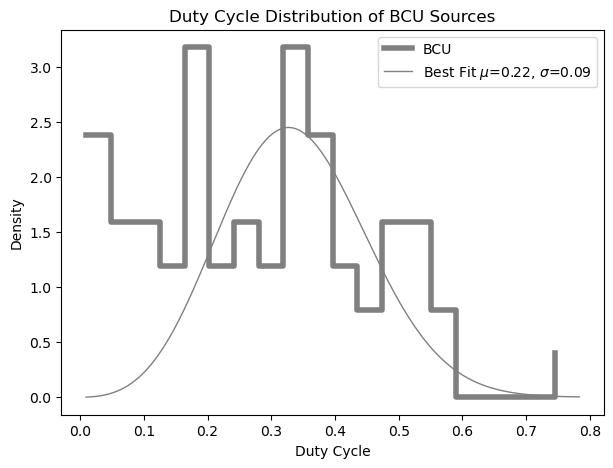

In [283]:
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


y_fsrq,xe_fsrq=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


maxfsrq=maxwellian_function(x_fsrq,0.1,a=0.1)
popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq,p0=[0.1,0.1],maxfev=5000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
maxfsrq = maxwellian_function(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1])

maxbll=maxwellian_function(x_bll,0.1,a=0.1)
popt_bll, pcov_bll = curve_fit(maxwellian_function, x_bll, y_bll,p0=[0.1,0.1],maxfev=5000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbll=maxwellian_function(x_bll_refine,popt_bll[0],popt_bll[1])

maxbcu=maxwellian_function(x_bcu,0.1,a=0.1)
popt_bcu, pcov_bcu = curve_fit(maxwellian_function, x_bcu, y_bcu,p0=[0.1,0.1],maxfev=5000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbcu = maxwellian_function(x_bcu_refine,popt_bcu[0],popt_bcu[1])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,maxbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle')
plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,maxbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle')
plt.title('Duty Cycle Distribution of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')
print(fsrq_mean,bll_mean)


In [79]:
print(x_fsrq[y_fsrq.argmax()])
print(x_bll[y_bll.argmax()])
print(x_bcu[y_bcu.argmax()])

0.24474666388657207
0.36630062961677634
0.29412228144320185


In [80]:
x_fsrq

array([0.02197352, 0.05910238, 0.09623123, 0.13336009, 0.17048895,
       0.20761781, 0.24474666, 0.28187552, 0.31900438, 0.35613324,
       0.39326209, 0.43039095, 0.46751981, 0.50464867, 0.54177752,
       0.57890638, 0.61603524, 0.6531641 , 0.69029295, 0.72742181])

In [168]:
stats.ks_2samp(data1=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),data2 = filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float))

KstestResult(statistic=np.float64(0.3354024829795755), pvalue=np.float64(7.587007727346903e-07), statistic_location=np.float64(0.30501710376282765), statistic_sign=np.int8(1))

### Plotting Distribution of New Flares

In [32]:
#FlareTable = pd.read_csv('COSI_BAND_ALL_weekly_RbkgUpdated0.10.csv', sep=",", na_filter=True)
FlareTable = COSI_BAND_BAT_weekly_df
fsrq_flares = FlareTable[FlareTable['Class']=='FSRQ']
fsrq_flares = fsrq_flares[fsrq_flares['Photon Flux (ph/cm2/s)']<100]
fsrq_flares = fsrq_flares[fsrq_flares['Photon Flux (ph/cm2/s)']>10e-12]
bll_flares = FlareTable[FlareTable['Class']=='BLL']
bll_flares = bll_flares[bll_flares['Photon Flux (ph/cm2/s)']<100]
bll_flares = bll_flares[bll_flares['Photon Flux (ph/cm2/s)']>10e-12]
bcu_flares = FlareTable[FlareTable['Class']=='BCU']
bcu_flares = bcu_flares[bcu_flares['Photon Flux (ph/cm2/s)']<100]
bcu_flares = bcu_flares[bcu_flares['Photon Flux (ph/cm2/s)']>10e-12]
FlareTable = FlareTable[FlareTable['Photon Flux (ph/cm2/s)']<100]
FlareTable = FlareTable[FlareTable['Photon Flux (ph/cm2/s)']>10e-12]

<function matplotlib.pyplot.show(close=None, block=None)>

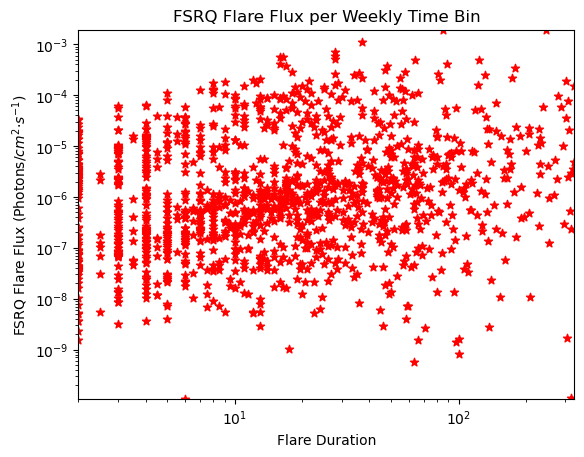

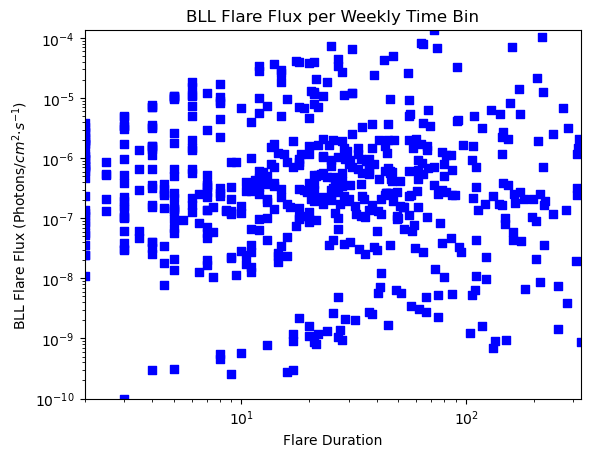

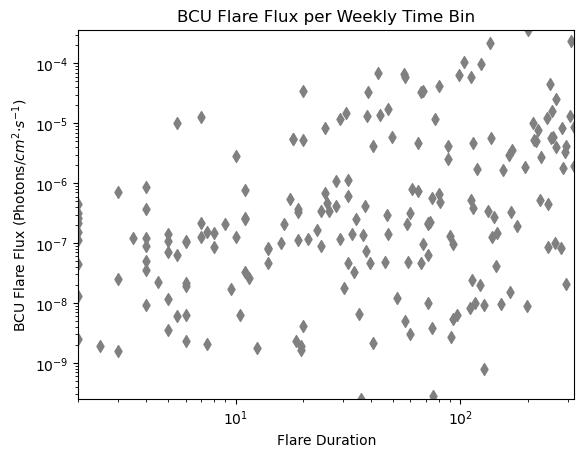

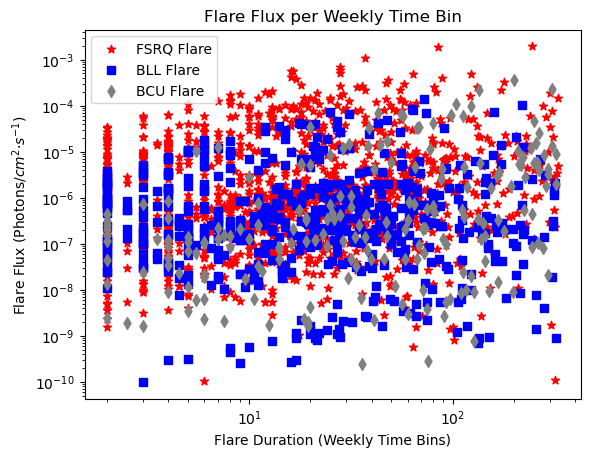

In [33]:
cl = ['r','blue','gray'] # List of colours for categories


# This section makes four Average Flux vs Duration plots: one for each category of blazars, and a final plot for all three together.
#print(pd.DataFrame(fsrq_flares[:,1]))
fsrq_ysize = fsrq_flares['Photon Flux (ph/cm2/s)'].size
fsrq_x = np.asarray(fsrq_flares['Duration (weeks)'],dtype='float64')
fsrq_xmin = min(fsrq_x)
fsrq_xmax = max(fsrq_x)
fsrq_y = np.asarray(fsrq_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
fsrq_ymin = min(fsrq_y)
fsrq_ymax = max(fsrq_y)
#fsrq_err= np.asarray(fsrq_plot[:,3],dtype='float64')
plt.ylim([fsrq_ymin,fsrq_ymax])
plt.xlim([fsrq_xmin,fsrq_xmax])
plt.scatter(fsrq_x,fsrq_y,marker = '*',color=cl[0])
#plt.errorbar(fsrq_x,fsrq_y,,fmt = '*',color='#FF005D')
plt.ylabel('FSRQ Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('FSRQ Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bll_ysize = bll_flares['Photon Flux (ph/cm2/s)'].size
bll_x = np.asarray(bll_flares['Duration (weeks)'],dtype='float64')
bll_xmin = min(bll_x)
bll_xmax = max(bll_x)
bll_y = np.asarray(bll_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
bll_ymin = min(bll_y)
bll_ymax = max(bll_y)
#bll_err= np.asarray(bll_plot[:,3],dtype='float64')
plt.ylim([bll_ymin,bll_ymax])
plt.xlim([bll_xmin,bll_xmax])
plt.scatter(bll_x,bll_y,marker = 's',color=cl[1])
#plt.errorbar(bll_x,bll_y,,fmt = '*',color='#FF005D')
plt.ylabel('BLL Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BLL Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bcu_ysize = bcu_flares['Photon Flux (ph/cm2/s)'].size
bcu_x = np.asarray(bcu_flares['Duration (weeks)'],dtype='float64')
bcu_xmin = min(bcu_x)
bcu_xmax = max(bcu_x)
bcu_y = np.asarray(bcu_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
bcu_ymin = min(bcu_y)
bcu_ymax = max(bcu_y)
#bcu_err= np.asarray(bcu_plot[:,3],dtype='float64')
plt.ylim([bcu_ymin,bcu_ymax])
plt.xlim([bcu_xmin,bcu_xmax])
plt.scatter(bcu_x,bcu_y,marker = 'd',color=cl[2])
#plt.errorbar(bcu_x,bcu_y,,fmt = '*',color='#FF005D')
plt.ylabel('BCU Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BCU Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()



#Combined Graphic
plt.scatter(fsrq_x,fsrq_y,marker = '*',color=cl[0],label='FSRQ Flare')
#plt.errorbar(fsrq_x,fsrq_y,yerr=fsrq_err,fmt = '*',color='#FF005D')
plt.scatter(bll_x,bll_y,marker = 's',color=cl[1],label='BLL Flare')
#plt.errorbar(bll_x,bll_y,yerr=bll_err,fmt = 's',color='#1E88E5')
plt.scatter(bcu_x,bcu_y,marker = 'd',color=cl[2],label='BCU Flare')
#plt.errorbar(bcu_x,bcu_y,yerr=bcu_err,fmt = 'd',color='#FFC107')
plt.legend()
plt.ylabel('Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration (Weekly Time Bins)')
plt.title('Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(10,40)
#plt.ylim(0.0000001,0.000002)
plt.show
#Flux is 1/cm^2*s


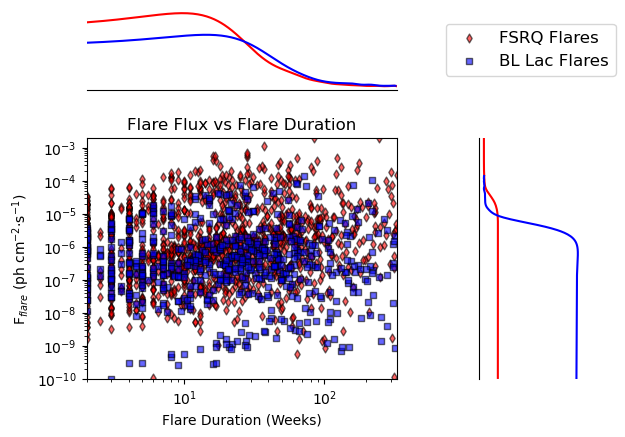

In [34]:
from matplotlib import gridspec

# Graph modified for Weekly Cadence
label = ['FSRQ Flares','BL Lac Flares','BCU Flares'] # List of labels for categories
cl = ['r','blue','gray'] # List of colours for categories
categories = len(label)


# Set up 4 subplots as axis objects using GridSpec:
gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])
# Add space between scatter plot and KDE plots to accommodate axis labels:
gs.update(hspace=0.3, wspace=0.4)

# Set background canvas colour to White instead of grey default
fig = plt.figure()
fig.patch.set_facecolor('white')

ax = plt.subplot(gs[1,0]) # Instantiate scatter plot area and axis range
#ax.set_ylim(10**-8,10**-5)
#ax.set_xlim(10,100)
ax.set_xlim(min(fsrq_xmin,bll_xmin), max(fsrq_xmax,bll_xmax))
ax.set_ylim(min(fsrq_ymin,bll_ymin), max(fsrq_ymax,bll_ymax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Flare Duration (Weeks)')
ax.set_ylabel('F$_{flare}$ (ph cm$^{-2}$\u22c5s$^{-1}$)')
ax.set_title('Flare Flux vs Flare Duration')

axl = plt.subplot(gs[1,1], sharey=ax) # Instantiate left KDE plot area
axl.get_xaxis().set_visible(False) # Hide tick marks and spines
axl.get_yaxis().set_visible(False)
axl.spines["right"].set_visible(False)
axl.spines["top"].set_visible(False)
axl.spines["bottom"].set_visible(False)

axb = plt.subplot(gs[0,0], sharex=ax) # Instantiate bottom KDE plot area
axb.get_xaxis().set_visible(False) # Hide tick marks and spines
axb.get_yaxis().set_visible(False)
axb.spines["right"].set_visible(False)
axb.spines["top"].set_visible(False)
axb.spines["left"].set_visible(False)

axc = plt.subplot(gs[0,1]) # Instantiate legend plot area
axc.axis('off') # Hide tick marks and spines

# Plot data for each categorical variable as scatter and marginal KDE plots:
#FSRQ PLOT
ax.scatter(fsrq_x, fsrq_y, marker = 'd', color = cl[0], label=label[0], s=20, edgecolors= 'black',alpha = 0.6)
#ax.errorbar(fsrq_x*3,fsrq_y,yerr=fsrq_err,fmt = '*',color='#FF005D')    
kde = stats.gaussian_kde(fsrq_x)
fsrq_xx = np.linspace(fsrq_xmin,fsrq_xmax,1000)
axb.plot(fsrq_xx,kde(fsrq_xx), color=cl[0],)
kde = stats.gaussian_kde(fsrq_y)
fsrq_yy = np.linspace(fsrq_ymin,fsrq_ymax,1000)
axl.plot(kde(fsrq_yy), fsrq_yy, color=cl[0])

#BLL PLOT
ax.scatter(bll_x,bll_y, marker = 's', color=cl[1], label=label[1], s=20, edgecolors = 'black',alpha = 0.6)
plt.xlim(np.log(10),np.max([np.max(fsrq_x.astype(float)),np.max(bll_x.astype(float))]))
#ax.errorbar(bll_x*3,bll_y,yerr=bll_err,fmt = 's',color='#1E88E5')
kde = stats.gaussian_kde(bll_x)
bll_xx = np.linspace(bll_xmin,bll_xmax,1000)
axb.plot(bll_xx, kde(bll_xx), color=cl[1])
kde = stats.gaussian_kde(bll_y)
bll_yy = np.linspace(bll_ymin,bll_ymax,1000)
axl.plot(kde(bll_yy), bll_yy, color=cl[1])

#BCU PLOT
#ax.scatter(bcu_x,bcu_y, marker = 'd', color=cl[2], label=label[2], s=20, edgecolor= cl[2])
#ax.errorbar(bcu_x*3,bcu_y,yerr=bcu_err,fmt = 'd',color='#FFC107')

#kde = stats.gaussian_kde(bcu_x)
#bcu_xx = np.linspace(bcu_xmin,bcu_xmax,1000)
#axb.plot(bcu_xx, kde(bcu_xx), color=cl[2])
#kde = stats.gaussian_kde(bcu_y)
#bcu_yy = np.linspace(bcu_ymin,bcu_ymax,1000)
#axl.plot(kde(bcu_yy), bcu_yy, color=cl[2])

# Copy legend object from scatter plot to lower left subplot and display:
# NB 'scatterpoints = 1' customises legend box to show only 1 handle (icon) per label 
handles, labels = ax.get_legend_handles_labels()
axc.legend(handles, labels, scatterpoints = 1, loc = 'center', fontsize = 12)
plt.show()

In [572]:
np.min(fsrq_x)

2.0

In [605]:

fsrq_filtered = fsrq_flares
fsrq_flareduration = fsrq_filtered['Duration (weeks)']
fsrq_flareflux = fsrq_filtered['Photon Flux (ph/cm2/s)']
#fsrq_flareflux_error = fsrq_filtered[]
fsrq_flareduration=np.asarray(fsrq_flareduration,dtype='float64')
fsrq_flareflux=np.asarray(fsrq_flareflux,dtype='float64')
#fsrq_flareflux_error=np.asarray(fsrq_flareflux_error,dtype='float64')
fsrq_fluence = np.multiply(fsrq_flareflux,fsrq_flareduration)*(7*24*60*60)
#fsrq_fluence_error = (np.multiply(fsrq_flareflux_error,fsrq_flareduration)**2)**0.5
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence)
fsrq_fluencecount = np.zeros(len(fsrq_fluence))
#fsrq_fluencecount_error = np.zeros(len(fsrq_fluence))
fsrq_fluencethresholds=sorted(fsrq_fluence)
for i in range(0,len(fsrq_fluence)):
    fsrq_fluencecount[i]=len(fsrq_fluence[fsrq_fluence>fsrq_fluencethresholds[i]])
    #fsrq_fluencecount_error[i]=fsrq_fluencecount[i]**0.5
pd.DataFrame(fsrq_fluencethresholds)

bll_filtered = bll_flares
bll_flareduration = bll_filtered['Duration (weeks)']
bll_flareflux = bll_filtered['Photon Flux (ph/cm2/s)']
#bll_flareflux_error = bll_filtered[:,3]
bll_flareduration=np.asarray(bll_flareduration,dtype='float64')
bll_flareflux=np.asarray(bll_flareflux,dtype='float64')
#bll_flareflux_error=np.asarray(bll_flareflux_error,dtype='float64')
bll_fluence = np.multiply(bll_flareflux,bll_flareduration)*(7*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence)
bll_fluencecount = np.zeros(len(bll_fluence))
#bll_fluencecount_error = np.zeros(len(bll_fluence))

bll_fluencethresholds=sorted(bll_fluence)
for i in range(0,len(bll_fluence)):
    bll_fluencecount[i]=len(bll_fluence[bll_fluence>bll_fluencethresholds[i]])
    #bll_fluencecount_error[i]=bll_fluencecount[i]**0.5

pd.DataFrame(bll_fluencethresholds)


bcu_filtered = bcu_flares
bcu_flareduration = bcu_filtered['Duration (weeks)']
bcu_flareflux = bcu_filtered['Photon Flux (ph/cm2/s)']
#bcu_flareflux_error = bcu_filtered[:,3]
bcu_flareduration=np.asarray(bcu_flareduration,dtype='float64')*(7*24*60*60)
bcu_flareflux=np.asarray(bcu_flareflux,dtype='float64')
#bcu_flareflux_error=np.asarray(bcu_flareflux_error,dtype='float64')
bcu_fluence = np.multiply(bcu_flareflux,bcu_flareduration)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence)
bcu_fluencecount = np.zeros(len(bcu_fluence))
#bcu_fluencecount_error = np.zeros(len(bcu_fluence))

bcu_fluencethresholds=sorted(bcu_fluence)
for i in range(0,len(bcu_fluence)):
    bcu_fluencecount[i]=len(bcu_fluence[bcu_fluence>bcu_fluencethresholds[i]])
    #bcu_fluencecount_error[i]=bcu_fluencecount[i]**0.5

pd.DataFrame(bcu_fluencethresholds)

total_filtered = FlareTable
total_flareduration = total_filtered['Duration (weeks)']
total_flareflux = total_filtered['Photon Flux (ph/cm2/s)']
#total_flareflux_error = total_filtered[:,3]
total_flareduration=np.asarray(total_flareduration,dtype='float64')
total_flareflux=np.asarray(total_flareflux,dtype='float64')
total_fluence = np.multiply(total_flareflux,total_flareduration)*(7*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence)
total_fluencecount = np.zeros(len(total_fluence))
#total_fluencecount_error = np.zeros(len(total_fluence))
total_fluencethresholds=sorted(total_fluence)
for i in range(0,len(total_fluence)):
    total_fluencecount[i]=len(total_fluence[total_fluence>total_fluencethresholds[i]])
    #total_fluencecount_error[i]=total_fluencecount[i]**0.5
print(max(total_fluencecount))

#np.save('shared_plot_arrays/FERMI_fsrq_fluencecount_0.1.npy',np.array(fsrq_fluencecount))
#np.save('shared_plot_arrays/FERMI_bll_fluencecount_0.1.npy',np.array(bll_fluencecount_error))
#np.save('shared_plot_arrays/FERMI_bcu_fluencecount_0.1.npy',np.array(bcu_fluencecount_error))


1846.0


In [608]:
fsrqDataframe = pd.DataFrame([fsrq_fluencecount,fsrq_fluencethresholds]).transpose()
fsrqDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

bllDataframe = pd.DataFrame([bll_fluencecount,bll_fluencethresholds]).transpose()
bllDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

bcuDataframe = pd.DataFrame([bcu_fluencecount,bcu_fluencethresholds]).transpose()
bcuDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

totalDataframe = pd.DataFrame([total_fluencecount,total_fluencethresholds]).transpose()
totalDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

fsrqDataframe.to_csv('shared_plot_arrays/FERMI_fsrq_fluence_curve_0.3.csv',index=False)
bllDataframe.to_csv('shared_plot_arrays/FERMI_bll_fluence_curve_0.3.csv',index=False)
bcuDataframe.to_csv('shared_plot_arrays/FERMI_bcu_fluence_curve_0.3.csv',index=False)
totalDataframe.to_csv('shared_plot_arrays/FERMI_total_fluence_curve_0.3.csv',index = False)

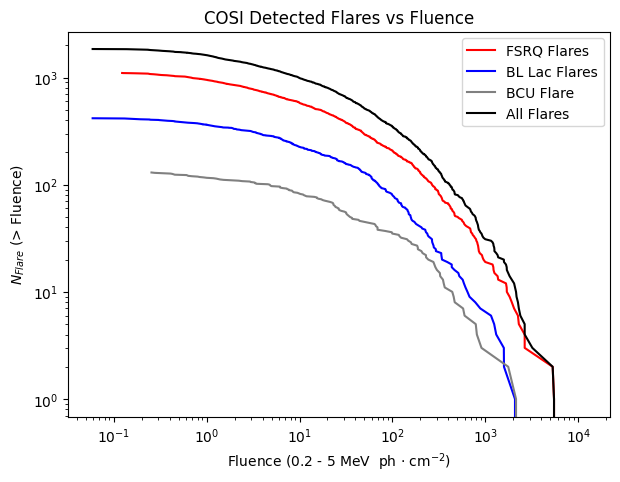

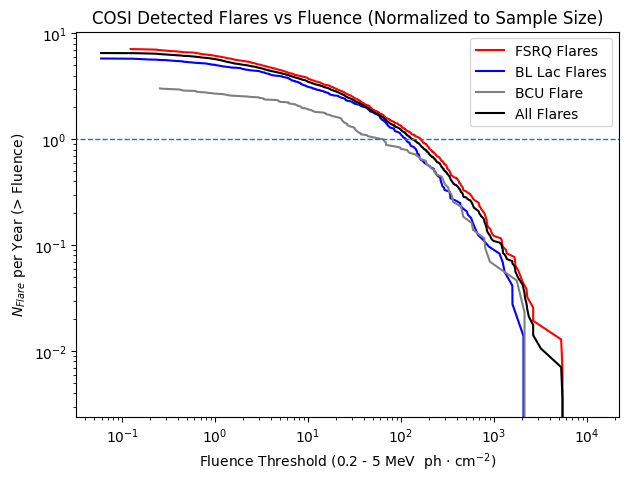

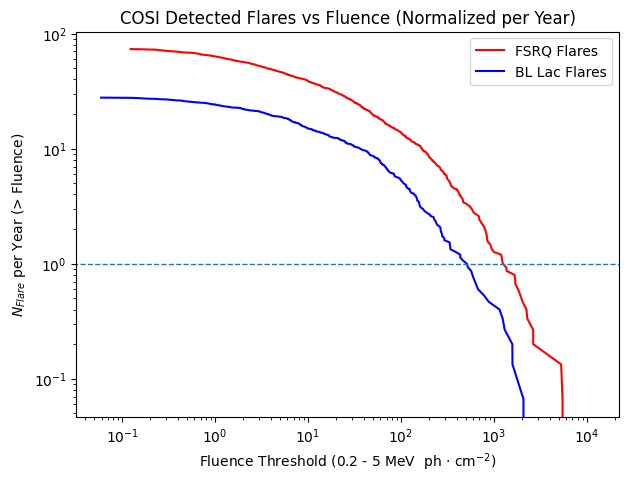

In [607]:
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['r','blue','gray','000000'] # List of colours for categories

fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount, color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount, yerr=fsrq_fluencecount_error, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')



plt.plot(bll_fluencethresholds,bll_fluencecount, color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount, yerr=bll_fluencecount_error, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')


plt.plot(bcu_fluencethresholds,bcu_fluencecount, color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount, yerr=bcu_fluencecount_error, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')


plt.plot(total_fluencethresholds,total_fluencecount, color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount, yerr=total_fluencecount_error, color=cl[3])
plt.yscale('log')
#plt.ylim(9,10**4)
#plt.xlim(10**-4,10**8)
plt.xscale('log')
plt.ylabel('$N_{Flare}$ (> Fluence)')
plt.xlabel('Fluence (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence')

plt.legend()

fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/len(fsrq_flares['Name'].drop_duplicates(keep='first')), color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount/15, yerr=fsrq_fluencecount_error/15, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/len(bll_flares['Name'].drop_duplicates(keep='first')), color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount/15, yerr=bll_fluencecount_error/15, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount/len(bcu_flares['Name'].drop_duplicates(keep='first')), color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount/15, yerr=bcu_fluencecount_error/15, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount/len(FlareTable['Name'].drop_duplicates(keep='first')), color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount/15, yerr=total_fluencecount_error/15, color=cl[3])
plt.yscale('log')
plt.xscale('log')
#plt.ylim(10/15,10**3)
#plt.xlim(10**-4,10**8)
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence (Normalized to Sample Size)')
plt.hlines(1,10**-10,10**10,linewidth=1,linestyles='--')
plt.legend()


fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/15, color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount/15, yerr=fsrq_fluencecount_error/15, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount/15, yerr=bll_fluencecount_error/15, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

#plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount/15, yerr=bcu_fluencecount_error/15, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

#plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount/15, yerr=total_fluencecount_error/15, color=cl[3])
plt.yscale('log')
plt.xscale('log')
#plt.ylim(10/15,10**3)
#plt.xlim(10**-4,10**8)
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence (Normalized per Year)')
plt.hlines(1,10**-10,10**10,linewidth=1,linestyles='--')
#plt.ylim(1,np.max(fsrq_fluencecount))

plt.legend()


In [ ]:


sourcename = '4FGL J1229.0+0202'
#
#if sourcename == '4FGL J1036.3-5833e':
#    continue
#if sourcename == '4FGL J1855.9+0121e':
#    continue
#if sourcename == '4FGL J1923.2+1408e':
#    continue

sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename

sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.nanmean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent
#thresholdflux = np.nanmean(photon_flux)
print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

if not sourcelightcurve.hops:
    print('no hops found in first run')

quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

if quiescent_background == np.nan:
    print('background is nan')
print('printing quiescent background')
print(quiescent_background)
#sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

#    if print(hops_bl[i]) == '(array([], dtype=int64),)':
#        continue
#    else:
hops_bl = sourcelightcurve.hops

hops_bl[1].asym

4.36e-06 3.54e-08 4.3246e-06 1.29738e-06 1.3327799999999998e-06
Quiescent Background: 2.672527439024391e-07, Error: 2.3783736555880743e-09
printing quiescent background
2.672527439024391e-07


-0.0625

In [453]:
lc_array[2][lc_array[1]=='FSRQ']

array([LightCurve (bins = 252, name = 4FGL J0001.5+2113, cadende = None, telescope = None, z = None),
       LightCurve (bins = 195, name = 4FGL J0019.6+7327, cadende = None, telescope = None, z = None),
       LightCurve (bins = 310, name = 4FGL J0030.3-4224, cadende = None, telescope = None, z = None),
       LightCurve (bins = 124, name = 4FGL J0051.5-4220, cadende = None, telescope = None, z = None),
       LightCurve (bins = 456, name = 4FGL J0102.8+5824, cadende = None, telescope = None, z = None),
       LightCurve (bins = 606, name = 4FGL J0108.6+0134, cadende = None, telescope = None, z = None),
       LightCurve (bins = 345, name = 4FGL J0112.8+3208, cadende = None, telescope = None, z = None),
       LightCurve (bins = 136, name = 4FGL J0116.0-1136, cadende = None, telescope = None, z = None),
       LightCurve (bins = 308, name = 4FGL J0118.9-2141, cadende = None, telescope = None, z = None),
       LightCurve (bins = 286, name = 4FGL J0133.1-5201, cadende = None, telescope

In [ ]:
fsrq_array = lc_array[2][lc_array[1]=='FSRQ']
bcu_array = lc_array[2][lc_array[1]=='BCU']
bll_array = lc_array[2][lc_array[1]=='BLL']

## Asymmetry

In [139]:
#COSI_BAND_BAT_weekly_df = pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts)_Softer.csv')
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.5Softer.csv')
asymmetrymatrix = COSI_BAND_BAT_weekly_df[['Asymmetry','Class']]
asymmetrymatrix = asymmetrymatrix[asymmetrymatrix['Asymmetry'] != '0.0']

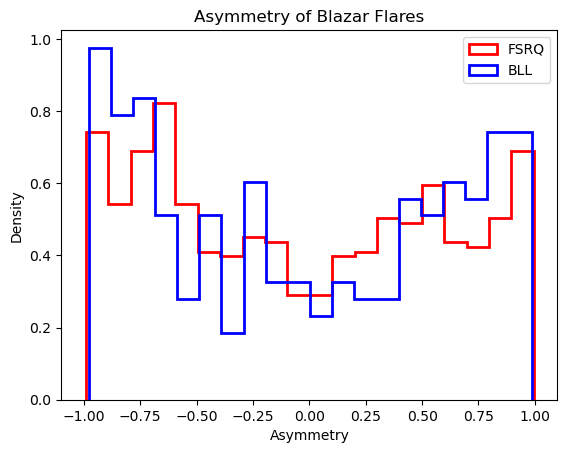

In [140]:
plt.figure()
plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=2)

plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=2)

#plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='gray',linewidth=2)

#plt.hist(x=asymmetrymatrix['Asymmetry'].astype(float),label='ALL',bins=20,density=True,histtype='step',color='black',linewidth=2)
plt.xlim(-1.1,1.1)
plt.title('Asymmetry of Blazar Flares')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()


<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/2205562540.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/2205562540.py:45: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

Text(0.5, 1.0, 'Asymmetry of BCU Sources')

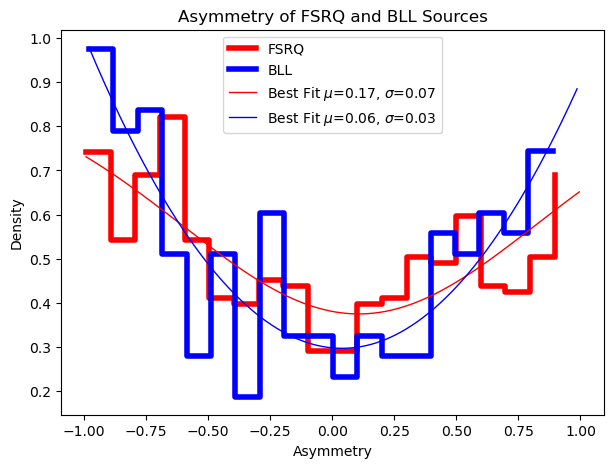

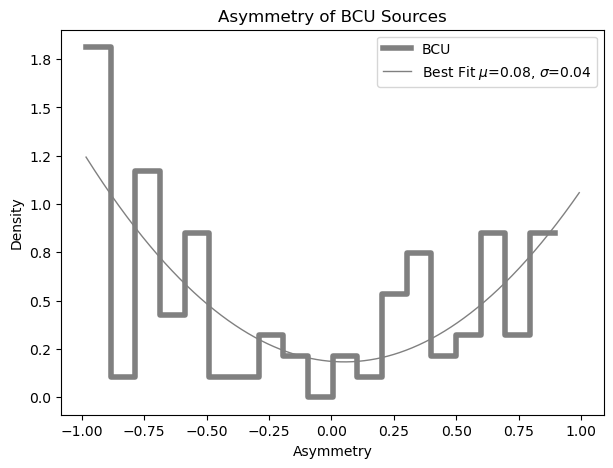

In [141]:
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def gaussianfunc(xVar,a,b,c,d):
    return a * np.exp(-(xVar - b) ** 2 / (2 *  c ** 2)) + d


y_fsrq,xe_fsrq=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


gaussfsrq=gaussianfunc(x_fsrq,a=0.1,b=0,c=0.1,d=0)
popt_fsrq, pcov_fsrq = curve_fit(gaussianfunc, x_fsrq, y_fsrq,p0=[0.1,0,0.1,0],maxfev = 10000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussfsrq = gaussianfunc(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1],popt_fsrq[2],popt_fsrq[3])

gaussbll=gaussianfunc(x_bll,a=0.1,b=0,c=0.1,d=0)
popt_bll, pcov_bll = curve_fit(gaussianfunc, x_bll, y_bll,p0=[0.1,0,0.1,0],maxfev = 10000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbll=gaussianfunc(x_bll_refine,popt_bll[0],popt_bll[1],popt_bll[2],popt_bll[3])

gaussbcu=gaussianfunc(x_bcu,a=0.1,b=0,c=0.1,d=0)
popt_bcu, pcov_bcu = curve_fit(gaussianfunc, x_bcu, y_bcu,p0=[0.1,0,0.1,0],maxfev = 10000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbcu = gaussianfunc(x_bcu_refine,popt_bcu[0],popt_bcu[1],popt_bcu[2],popt_bcu[3])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,gaussbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,gaussbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/1424120370.py:63: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/1424120370.py:63: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

Text(0.5, 1.0, 'Asymmetry of BCU Sources')

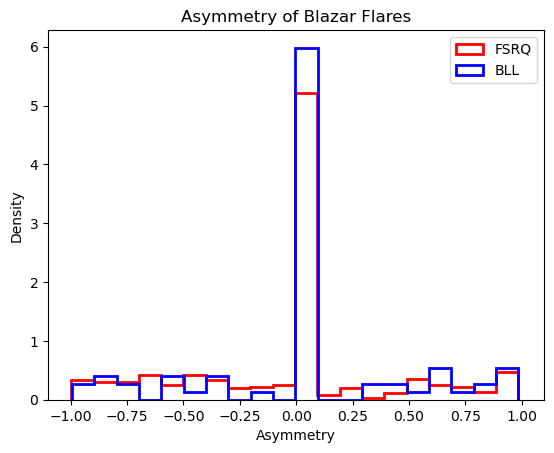

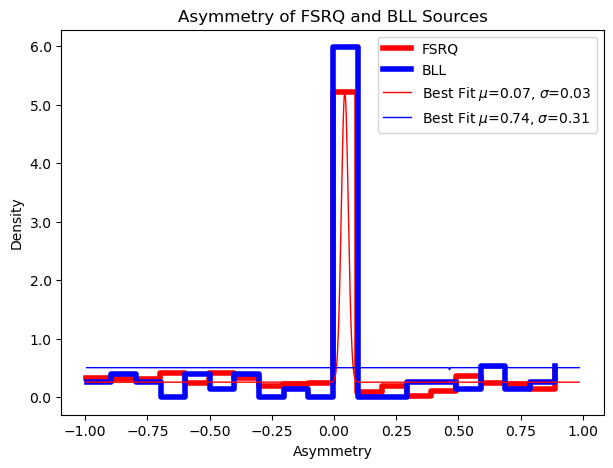

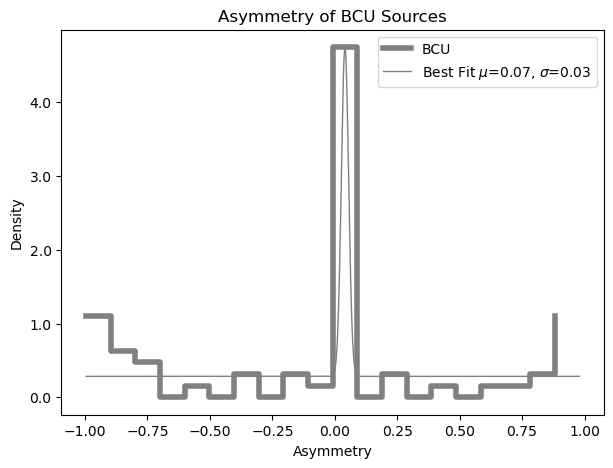

In [142]:
COSI_BAND_BAT_weekly_df2 = pd.read_csv('Aug2025_COSI_0.1_(0.1 Counts).csv')
asymmetrymatrix = COSI_BAND_BAT_weekly_df2[['Asymmetry','Class']]
asymmetrymatrix = asymmetrymatrix[asymmetrymatrix['Asymmetry'] != '0.0']

plt.figure()
plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=2)

plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=2)

#plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='gray',linewidth=2)

#plt.hist(x=asymmetrymatrix['Asymmetry'].astype(float),label='ALL',bins=20,density=True,histtype='step',color='black',linewidth=2)
plt.xlim(-1.1,1.1)
plt.title('Asymmetry of Blazar Flares')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()

from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def gaussianfunc(xVar,a,b,c,d):
    return a * np.exp(-(xVar - b) ** 2 / (2 *  c ** 2)) + d


y_fsrq,xe_fsrq=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


gaussfsrq=gaussianfunc(x_fsrq,a=0.1,b=0,c=0.1,d=0)
popt_fsrq, pcov_fsrq = curve_fit(gaussianfunc, x_fsrq, y_fsrq,p0=[0.1,0,0.1,0],maxfev = 10000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussfsrq = gaussianfunc(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1],popt_fsrq[2],popt_fsrq[3])

gaussbll=gaussianfunc(x_bll,a=0.1,b=0,c=0.1,d=0)
popt_bll, pcov_bll = curve_fit(gaussianfunc, x_bll, y_bll,p0=[0.1,0,0.1,0],maxfev = 10000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbll=gaussianfunc(x_bll_refine,popt_bll[0],popt_bll[1],popt_bll[2],popt_bll[3])

gaussbcu=gaussianfunc(x_bcu,a=0.1,b=0,c=0.1,d=0)
popt_bcu, pcov_bcu = curve_fit(gaussianfunc, x_bcu, y_bcu,p0=[0.1,0,0.1,0],maxfev = 10000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbcu = gaussianfunc(x_bcu_refine,popt_bcu[0],popt_bcu[1],popt_bcu[2],popt_bcu[3])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,gaussbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,gaussbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')

